# Create figures for hyperparameter value comparison
### Optimal Model
Loading the run.

In [1]:
import mlflow
from torch import device

In [2]:
experiment = '929917654968280603'
run = 'a989ec5a26ee47af946a8736104fbd9d'

In [3]:
with mlflow.start_run(run_id="a989ec5a26ee47af946a8736104fbd9d") as runner:
    
    model_uri = "/".join(("mlruns", experiment , runner.info.run_id , "artifacts","model@ep500"))
    print(f"loading model from path: {model_uri}")
    loaded_model = mlflow.pytorch.load_model(model_uri, map_location=device('cpu'))

2024/07/17 13:57:12 WARNING mlflow.pytorch: Stored model version '2.3.0+cu121' does not match installed PyTorch version '2.2.2'


loading model from path: mlruns/929917654968280603/a989ec5a26ee47af946a8736104fbd9d/artifacts/model@ep500


#### Plot the training and validation loss

Loading 10 samples.

In [4]:
from torch import load
from operator import itemgetter
from os import path

In [5]:
DATAPATH = '../model3Delastic/data/data_files/' 

n_sample = 128

key_dataset = DATAPATH + "data_elasticity_3D_res64.pt"
if path.exists(key_dataset):
    input, target = itemgetter('young_modulus', 'stress')(load(key_dataset, map_location=device('cpu')))
    input, target = input[:1], target[:1]

In [6]:
output = loaded_model(input.unsqueeze(1)).squeeze(1)

Create the arrays of errors and stress values.

In [7]:
import numpy as np

In [8]:
stress = target.detach().numpy().flatten()
errors = (target-output).abs().detach().numpy().flatten()

Draw graphs of errors vs stress values.

In [26]:
from seaborn import kdeplot
from seaborn import displot
import matplotlib.pyplot as plt
import pandas as pd

In [43]:
data = pd.DataFrame({"stress": stress, "errors": errors})

data['Mean Error Status'] = errors > errors.mean()
dict_sup = {True: "Error > MAE", False: "Error < MAE"}
data['Mean Error Status'] = data['Mean Error Status'].map(dict_sup)

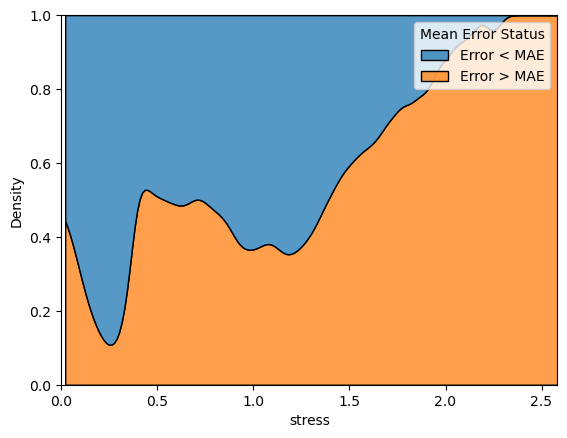

In [44]:
fig, ax = plt.subplots()
kdeplot(data=data, x='stress', hue='Mean Error Status', multiple='fill', ax=ax)
ax.set_xlim(0, stress.max())
plt.show()

Draw graphs of stress distribution and error distribution

In [29]:
data = pd.DataFrame({"stress": stress, "errors": errors})

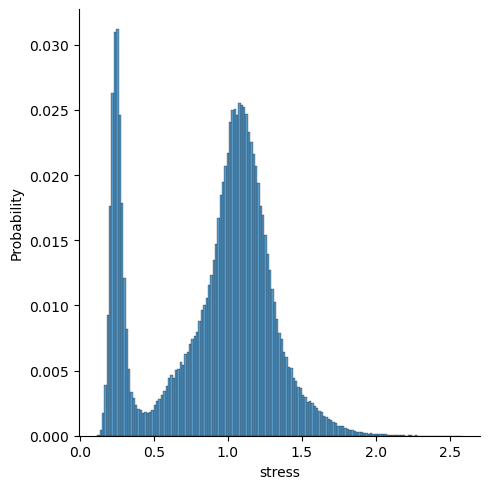

In [35]:
# fig, ax = plt.subplots()
displot(
    data=data, x="stress", stat='probability', common_norm=False
)
# plt.show()

#### Training curve

In [103]:
path_to_metrics = "/".join(("mlruns", experiment, run, "metrics"))
data = pd.DataFrame()
temp = pd.read_csv(path_to_metrics + "/training MAE", sep=" ", names= ["1","2","3"])[:507]
data[["Training","Epochs"]] = temp[["2", "3"]]
temp = pd.read_csv(path_to_metrics + "/testing MAE", sep=" ", names= ["1","2","3"])[:507]
data["Testing"] = temp["2"]


In [104]:
data

,Training,Epochs,Testing
0,1.035798,1,0.925599
1,0.755529,2,0.425992
2,0.230476,3,0.188850
3,0.168960,4,0.165286
4,0.159502,5,0.161323
...,...,...,...
502,0.011836,503,0.012853
503,0.012923,504,0.020968
504,0.017531,505,0.012429
505,0.013666,506,0.012484


Generate graph.

In [105]:
from seaborn import lineplot

In [106]:
data = pd.melt(data, id_vars=['Epochs'], value_name='Mean Absolute Error')

In [107]:
data

,Epochs,variable,Mean Absolute Error
0,1,Training,1.035798
1,2,Training,0.755529
2,3,Training,0.230476
3,4,Training,0.168960
4,5,Training,0.159502
...,...,...,...
1009,503,Testing,0.012853
1010,504,Testing,0.020968
1011,505,Testing,0.012429
1012,506,Testing,0.012484


In [ ]:
style_dict = {'Training': '-', 'Testing': '--'}

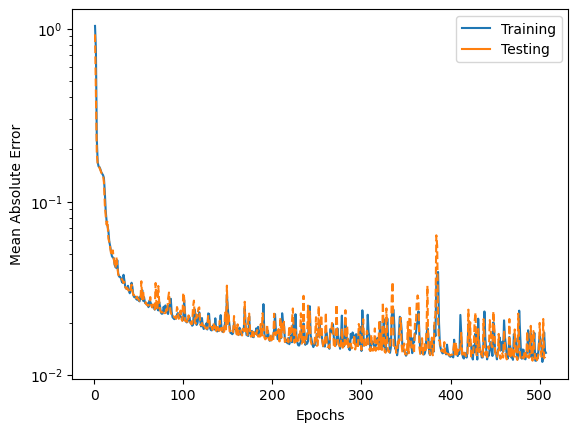

In [112]:
fig, ax = plt.subplots()
lineplot(data=data, x='Epochs', y= 'Mean Absolute Error', hue='variable')
ax.set_yscale('log')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[2:], labels=labels[2:])
ax.lines[1].set_linestyle("--")
plt.show()

## Data Augmentation

We will save the min value of all the runs and compare them.
First, we list the active runs in the experiment

In [12]:
from mlflow import MlflowClient
from mlflow.entities import ViewType
import pandas as pd

In [13]:
experiment = "298446340849721077"
client = MlflowClient()
runs = client.search_runs(experiment_ids=experiment, run_view_type=ViewType.ACTIVE_ONLY)


In [56]:
def augmentation_name(run_name):
    if "no augmentation" in run_name:
        return "N"
    elif "rotation in x" in run_name:
        return "N * 2"
    elif "rotation in y" in run_name:
        return "N * 3"
    elif "rotation in z" in run_name:
        return "N * 4"
    elif "flip in y,z only" in run_name:
        return "N * 2\nby flipping"
    elif "flip in y,z" in run_name:
        return "N * 5"
    else:
        print(run_name)
        raise Exception()
    
def augmentation_value(run_name):
    if "no augmentation" in run_name:
        return 1
    elif "rotation in x" in run_name:
        return 2
    elif "rotation in y" in run_name:
        return 3
    elif "rotation in z" in run_name:
        return 4
    elif "flip in y,z only" in run_name:
        return 2
    elif "flip in y,z" in run_name:
        return 5
    else:
        print(run_name)
        raise Exception()
    
def retrieve_min(run):
    path_values = "/".join(("mlruns", experiment, run.info.run_id, "metrics","testing MAE"))
    max_epoch = int(200/augmentation_value(run_name=run.info.run_name))
    return pd.read_csv(path_values, sep=" ", usecols=[1], names=["1"]).iloc[:max_epoch].min()['1'], pd.read_csv(path_values, sep=" ", usecols=[1], names=["1"]).iloc[:max_epoch].idxmin()['1']

In [57]:
retrieve_min(runs[0])

(0.0525865741074085, 96)

Map the run names to their augmentation type

Create dataframe

In [67]:
# data_dict_keys = ["MAE Decrease per example", "Dataset size"] # The right study
# data_dict_keys = ["MAE Decrease per second", "Dataset size"] # The right study
data_dict_keys = ["Test MAE", "Dataset size"] # The right study
# data_dict_keys = ["Training Time [s]", "Dataset size"] # The right study

data_dict = {data_dict_keys[0]: list(), data_dict_keys[1]: list()} # Classic study

for run in runs:
    augmentation_mode= augmentation_name(run.info.run_name)
    data_dict[data_dict_keys[1]].append(augmentation_mode)
    total_decrease, epoch_decrease = retrieve_min(run=run)
    training_time = run.data.metrics['training_time']
    number_of_examples = augmentation_value(run_name=run.info.run_name)*float(run.data.params['n_samples'])*epoch_decrease
    # run_graph_value = (0.9 - total_decrease)/number_of_examples
    # run_graph_value = (0.9 - total_decrease)/training_time
    run_graph_value = total_decrease
    # run_graph_value = training_time
    data_dict[data_dict_keys[0]].append(run_graph_value)
sorter= ["N",
         "N * 2",
         "N * 2\nby flipping",
         "N * 3",
         "N * 4",
         "N * 5"]
data=pd.DataFrame(data_dict).sort_values(by="Dataset size", key=lambda column: column.map(lambda e: sorter.index(e)))

In [68]:
from seaborn import violinplot

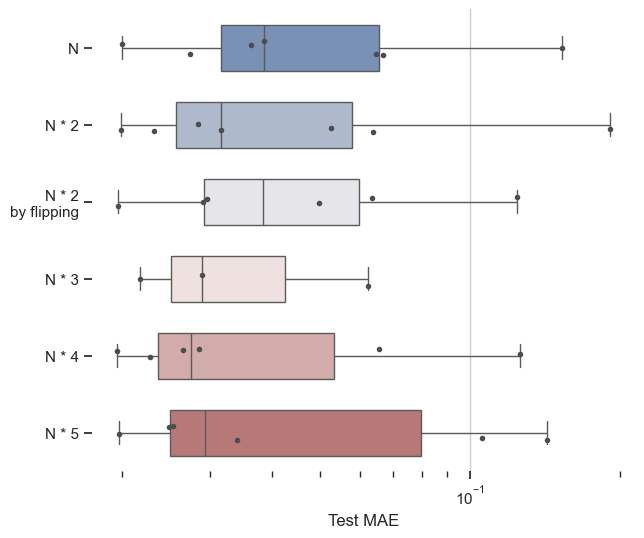

In [69]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="ticks")

# Initialize the figure with a logarithmic x axis
f, ax = plt.subplots(figsize=(7, 6))
ax.set_xscale("log")

# Plot the orbital period with horizontal boxes
sns.boxplot(
    data, x=data_dict_keys[0], y=data_dict_keys[1], hue=data_dict_keys[1], width=.6, palette="vlag"
)

# Add in points to show each observation
sns.stripplot(data, x=data_dict_keys[0], y=data_dict_keys[1], size=4, color=".3")

# Tweak the visual presentation
ax.xaxis.grid(True)
ax.set(ylabel="")
sns.despine(trim=True, left=True)

<Axes: xlabel='Test MAE', ylabel='Dataset size'>

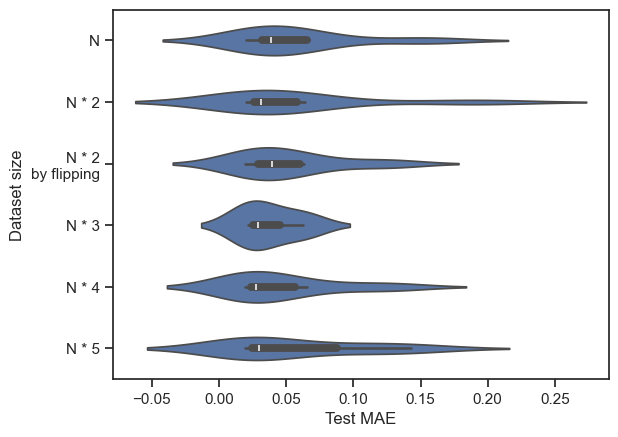

In [70]:
violinplot(data=data, y=data_dict_keys[1], x=data_dict_keys[0], fill=True)

### Same study using the number of examples

## Batch size

In [50]:
from mlflow import MlflowClient
from mlflow.entities import ViewType

In [59]:
experiment = "558424536518409256"
client = MlflowClient()
runs = client.search_runs(experiment_ids=experiment, run_view_type=ViewType.ACTIVE_ONLY)


In [60]:
def retrieve_min(run_id):
    path_values = "/".join(("mlruns", experiment, run_id, "metrics","testing MAE"))
    return pd.read_csv(path_values, sep=" ", usecols=[1], names=["1"]).min()['1']

In [79]:
data_dict_keys = ["Batch size", "Mean Decrease per example"] # The right study
data_dict = {data_dict_keys[0]: list(), data_dict_keys[1]: list()} # Classic study

for run in runs:
    batch_size = run.data.params['batch_size']
    data_dict[data_dict_keys[0]].append(batch_size)
    run_graph_value = (0.9 - retrieve_min(run_id=run.info.run_id))/float(run.data.params['total_training_examples']) # The right study
    data_dict[data_dict_keys[1]].append(run_graph_value)
data=pd.DataFrame(data_dict).astype({'Batch size': 'int32'}).sort_values(by="Batch size").astype({'Batch size': 'str'})
data    

,Batch size,Mean Decrease per example
16,8,0.000004
10,8,0.000005
4,8,0.000014
3,16,0.000005
9,16,0.000009
15,16,0.000004
14,32,0.000004
8,32,0.000005
2,32,0.000004
13,64,0.000004


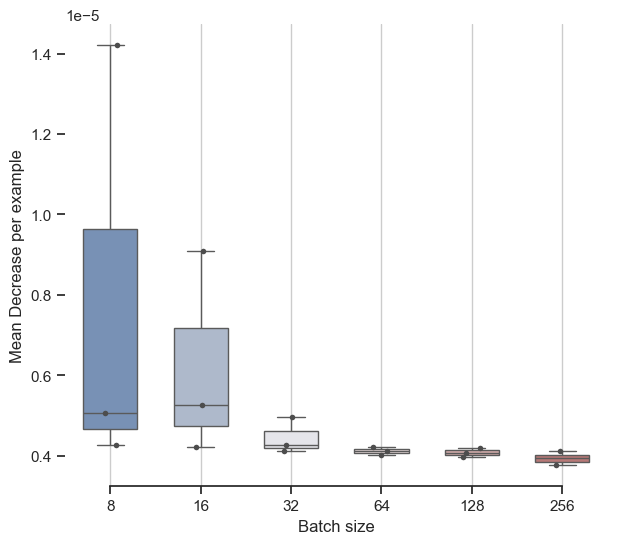

In [80]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="ticks")

# Initialize the figure with a logarithmic x axis
f, ax = plt.subplots(figsize=(7, 6))

# Plot the orbital period with vertical boxes
sns.boxplot(
    data, x=data_dict_keys[0], y=data_dict_keys[1], hue=data_dict_keys[0], width=.6, palette="vlag"
)

# Add in points to show each observation
sns.stripplot(data, x=data_dict_keys[0], y=data_dict_keys[1], size=4, color=".3")

# Tweak the visual presentation
ax.xaxis.grid(True)
ax.set(ylabel=data_dict_keys[1])
sns.despine(trim=True, left=True)